## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
#!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
#!unzip ml-1m.zip
#!cat ml-1m/README

In [2]:
import pandas as pd
import numpy as np
from typing import Union
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
df['datetime'].min(),df['datetime'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [6]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [7]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [8]:
user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [9]:
[df_train['user_id'].nunique(), df_train['user_id'].max(), df_train['user_id'].max(),
df_train['item_id'].nunique(), df_train['item_id'].min(), df_train['item_id'].max(),
df_train['rating'].nunique(), df_train['rating'].min(),df_train['rating'].max()]

[5365, 5364, 5364, 3010, 0, 3009, 5, 1, 5]

In [10]:
df_train.shape

(787420, 4)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [11]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    df_matrix = df.pivot(index='user_id', columns='item_id', values='rating')
    df_matrix = df_matrix.fillna(0)

    print(f"Размер матрицы в pd: {df_matrix.shape}")
    print(f"\n{df_matrix.head(2)}")


    result = df_matrix.to_numpy()
    
    
    print(f"\nРазмер матрицы в np:{result.shape}")
    print(f"\n{result[2:]}")

    user_ids = df_matrix.index.to_numpy()
    item_ids = df_matrix.columns.to_numpy()

    print(f"\nuser_id: {user_ids}")
    print(f"item_id: {item_ids}")
    
    return result #shape ~ [n_users, n_items]

In [12]:
interactions = df_to_matrix(df_train)

Размер матрицы в pd: (5365, 3010)

item_id  0     1     2     3     4     5     6     7     8     9     ...  \
user_id                                                              ...   
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  
user_id                                                              
0         0.0   0.0   0.0   0.0   0.0   1.0   4.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 3010 columns]

Размер матрицы в np:(5365, 3010)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]

user_id: [   0    1    2 ... 5362 5363 5364]
item_id: [   0    1    2 ... 3007 3008 3009]


In [13]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    result = coo_array((df["rating"], (df["user_id"], df["item_id"])))

    return result # coo_array

In [14]:
coo_interactions = df_to_coo(df_train)
print(coo_interactions.shape)
print(coo_interactions)

(5365, 3010)
  (0, 2994)	3
  (0, 929)	4
  (0, 567)	4
  (0, 3005)	1
  (0, 3006)	4
  (0, 1533)	3
  (0, 1539)	3
  (0, 1541)	2
  (0, 957)	3
  (0, 1549)	2
  (0, 2301)	5
  (0, 1554)	2
  (0, 666)	4
  (0, 672)	4
  (0, 674)	5
  (0, 681)	3
  (0, 682)	2
  (0, 685)	5
  (0, 687)	3
  (0, 691)	3
  (0, 1815)	2
  (0, 718)	3
  (0, 2355)	3
  (0, 1219)	2
  (0, 2467)	2
  :	:
  (5364, 2119)	4
  (5364, 2122)	1
  (5364, 449)	5
  (5364, 1473)	1
  (5364, 456)	4
  (5364, 1479)	5
  (5364, 1480)	4
  (5364, 2852)	4
  (5364, 1488)	5
  (5364, 462)	4
  (5364, 801)	5
  (5364, 803)	2
  (5364, 469)	4
  (5364, 1489)	3
  (5364, 1490)	3
  (5364, 1491)	5
  (5364, 1497)	5
  (5364, 804)	4
  (5364, 812)	4
  (5364, 813)	3
  (5364, 814)	1
  (5364, 817)	5
  (5364, 478)	5
  (5364, 819)	4
  (5364, 820)	4


In [15]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [16]:
from scipy.sparse.linalg import svds
from numpy.linalg import svd

In [17]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    min_dim = min(interractions.shape)
    print(f"\nТип матрицы: {type(interractions)}")

    if n_singular_values > min_dim:
        raise ValueError(f"\nn_singular_values не может быть больше {min_dim}")
    
    if isinstance(interractions, coo_array):
        interractions_float = interractions.astype(float)
        k = min_dim - 1 if n_singular_values == -1 or n_singular_values == min_dim else n_singular_values
        print(f"Используем scipy svds с k={k}")
        U, S, V = svds(interractions_float, k=int(k))

    else:
        if n_singular_values == -1 or n_singular_values == min_dim:
            print("Используем numpy svd")
            U, S, V = svd(interractions)
            
            U = U[:, :min_dim]
            S = S[:min_dim]
            V = V[:min_dim, :]

        else:
            k = n_singular_values
            print(f"Используем scipy svds с k={k}")
            U, S, V = svds(interractions, k=int(k))

    S = np.diag(S)
    print(f"Размер U = {U.shape}")
    print(f"Размер S = {S.shape}")
    print(f"Размер V = {V.shape}")

    return U, S, V

In [18]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)


Тип матрицы: <class 'numpy.ndarray'>
Используем numpy svd
Размер U = (5365, 3010)
Размер S = (3010, 3010)
Размер V = (3010, 3010)


In [19]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)


Тип матрицы: <class 'numpy.ndarray'>
Используем scipy svds с k=10
Размер U = (5365, 10)
Размер S = (10, 10)
Размер V = (10, 3010)

Тип матрицы: <class 'scipy.sparse._coo.coo_array'>
Используем scipy svds с k=10
Размер U = (5365, 10)
Размер S = (10, 10)
Размер V = (10, 3010)


##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [20]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    
    U, S, V = make_svd(interactions, n_singular_values)
    recs = U @ S @ V

    if isinstance(interactions, coo_array):
        mask = (interactions.todense() > 0) 
    else:
        mask = (interactions > 0)
    
    recs[mask] = -np.inf
    recs[recs < np.percentile(recs, 10)] = -np.inf 

    n_users = recs.shape[0]
    recommendations = np.full((n_users, top_k), -1, dtype=int)

    for user_idx, scores in enumerate(recs):
        sorted_items = np.argsort(-scores)
        valid_items = sorted_items[scores[sorted_items] != -np.inf][:top_k]
        recommendations[user_idx, :len(valid_items)] = valid_items

    print("Размер recommendations =", recommendations.shape)

    return recommendations  # shape = [n_users, top_k]

In [21]:
recs = make_svd_recommendations(interactions, 100)
assert recs.shape == (interactions.shape[0], 100)


Тип матрицы: <class 'numpy.ndarray'>
Используем scipy svds с k=100
Размер U = (5365, 100)
Размер S = (100, 100)
Размер V = (100, 3010)
Размер recommendations = (5365, 100)


In [22]:
# тестыыыыыы

def test():

    interactions = np.array([
        [5, 0, 3, 0, 0, 1],
        [4, 0, 0, 2, 0, 0],
        [0, 1, 0, 0, 0, 5],
        [0, 0, 3, 0, 4, 0],
        [2, 0, 0, 3, 0, 0]
    ], dtype=float)

    top_k = 2
    recommendations = make_svd_recommendations(interactions, n_singular_values=2, top_k=top_k)
    print(f"\nРекомендации: \n{recommendations}")

    for user_idx in range(interactions.shape[0]):
        interacted_items = set(np.where(interactions[user_idx] > 0)[0])
        recommended_items = set(recommendations[user_idx])

        print(f"\nuser_idx {user_idx}:")
        print(f"interacted_items: {sorted(interacted_items)}")
        print(f"recommended_items: {sorted(recommended_items)}")

test()


Тип матрицы: <class 'numpy.ndarray'>
Используем scipy svds с k=2
Размер U = (5, 2)
Размер S = (2, 2)
Размер V = (2, 6)
Размер recommendations = (5, 2)

Рекомендации: 
[[3 4]
 [2 4]
 [2 4]
 [5 0]
 [2 1]]

user_idx 0:
interacted_items: [0, 2, 5]
recommended_items: [3, 4]

user_idx 1:
interacted_items: [0, 3]
recommended_items: [2, 4]

user_idx 2:
interacted_items: [1, 5]
recommended_items: [2, 4]

user_idx 3:
interacted_items: [2, 4]
recommended_items: [0, 5]

user_idx 4:
interacted_items: [0, 3]
recommended_items: [1, 2]


c:\Users\Nikita\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [23]:
import time
import matplotlib.pyplot as plt

In [24]:
def ndcg_metric(gt_items, predicted):
    if len(predicted) == 0:
        return 0.0

    predicted = [x for x in predicted if x != -1]

    if len(predicted) == 0:
        return 0.0

    at = len(predicted)
    relevance = np.array([1 if x in gt_items else 0 for x in predicted])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_relevance = np.ones(min(len(gt_items), at))
    ideal_dcg = dcg(ideal_relevance)

    if ideal_dcg == 0.0:
        return 0.0
    return rank_dcg / ideal_dcg

def dcg(scores):
    return np.sum(
        (np.power(2, scores) - 1) / np.log2(np.arange(scores.shape[0]) + 2),
        dtype=np.float64
    )

In [25]:
def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    n_singular_values_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    execution_times = []

    n_users, n_items = interactions.shape
    
    ground_truth = [np.random.choice(n_items, size=5, replace=False) for _ in range(n_users)]

    for n_singular_values in n_singular_values_list:
        start_time = time.time() 
        
        recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)

        ndcg_score = np.mean([ndcg_metric(gt, recs) for gt, recs in zip(ground_truth, recommendations)])
        ndcg_scores.append(ndcg_score)

        execution_time = time.time() - start_time
        execution_times.append(execution_time)

        print(f"\nn_singular_values = {n_singular_values}")
        print(f"NDCG@{top_k}: {ndcg_score:.4f}")
        print(f"Время работы: {execution_time:.2f} сек")

    plt.figure(figsize=(10, 5))
    plt.plot(n_singular_values_list, ndcg_scores, marker='o', linestyle='-', label='NDCG@top_k')
    plt.xlabel("Число сингулярных значений (n_singular_values)")
    plt.ylabel("NDCG@top_k")
    plt.title("Качество рекомендаций (NDCG) в зависимости от n_singular_values")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(n_singular_values_list, execution_times, marker='s', linestyle='-', label="Время работы (сек)")
    plt.xlabel("Число сингулярных значений (n_singular_values)")
    plt.ylabel("Время работы (сек)")
    plt.title("Время работы алгоритма в зависимости от n_singular_values")
    plt.legend()
    plt.grid()
    plt.show()


Тип матрицы: <class 'scipy.sparse._coo.coo_array'>
Используем scipy svds с k=1
Размер U = (5365, 1)
Размер S = (1, 1)
Размер V = (1, 3010)
Размер recommendations = (5365, 100)

n_singular_values = 1
NDCG@100: 0.0115
Время работы: 2.58 сек

Тип матрицы: <class 'scipy.sparse._coo.coo_array'>
Используем scipy svds с k=10
Размер U = (5365, 10)
Размер S = (10, 10)
Размер V = (10, 3010)
Размер recommendations = (5365, 100)

n_singular_values = 10
NDCG@100: 0.0115
Время работы: 2.51 сек

Тип матрицы: <class 'scipy.sparse._coo.coo_array'>
Используем scipy svds с k=50
Размер U = (5365, 50)
Размер S = (50, 50)
Размер V = (50, 3010)
Размер recommendations = (5365, 100)

n_singular_values = 50
NDCG@100: 0.0122
Время работы: 3.21 сек

Тип матрицы: <class 'scipy.sparse._coo.coo_array'>
Используем scipy svds с k=200
Размер U = (5365, 200)
Размер S = (200, 200)
Размер V = (200, 3010)
Размер recommendations = (5365, 100)

n_singular_values = 200
NDCG@100: 0.0115
Время работы: 4.91 сек

Тип матрицы: <c

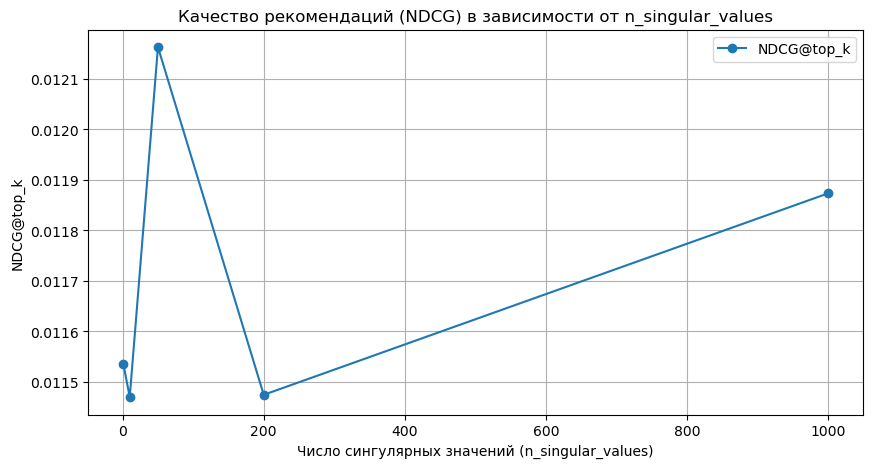

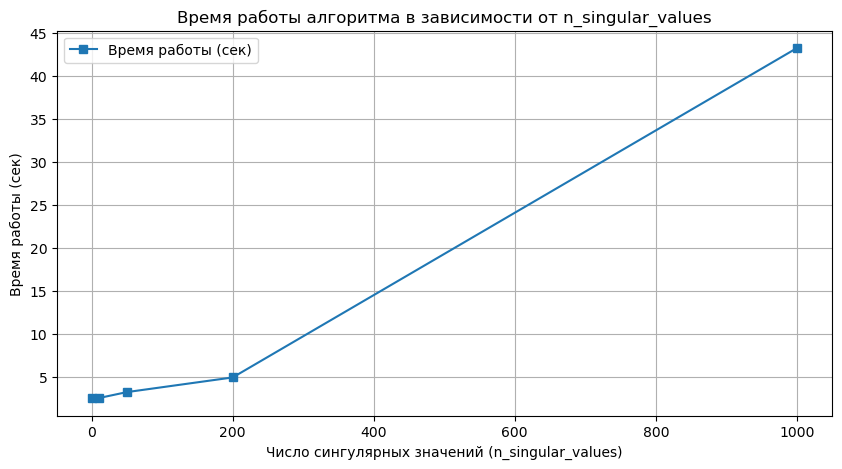

In [26]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [28]:
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import time

def make_als_recommendations(
    interactions: np.ndarray,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
    iterations: int = 15,
):

    interactions_sparse = csr_matrix(interactions)
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=iterations,
    )
    
    model.fit(interactions_sparse * alpha, show_progress=True)
    
    user_ids = np.arange(interactions.shape[0]) 
    recommendations = model.recommend_all(interactions_sparse, N=top_k, filter_already_liked_items=True)
    
    return recommendations

def evaluate_model(interactions_train, interactions_test, n_factors, regularization, alpha, iterations):

    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=iterations,
    )
    interactions_train_sparse = csr_matrix(interactions_train)
    model.fit(interactions_train_sparse * alpha, show_progress=False)
    
    recommendations = model.recommend_all(interactions_train_sparse, N=100, filter_already_liked_items=True)
    
    ndcg_scores = [ndcg_metric(gt, recommendations[i]) for i, gt in enumerate(ground_truth)]
    mean_ndcg = np.mean(ndcg_scores)
    return mean_ndcg

interactions_train = df_to_matrix(df_train)
interactions_test = df_to_matrix(df_test)

ground_truth = [np.nonzero(interactions_test[i])[0] for i in range(interactions_test.shape[0])]

param_grid = {
    "n_factors": [10, 50, 100, 200],
    "regularization": [0.001, 0.01, 0.1, 1],
    "alpha": [0.1, 1, 10],
    "iterations": [5, 15, 30],
}

best_params = None
best_score = -np.inf

for n_factors in param_grid["n_factors"]:
    for regularization in param_grid["regularization"]:
        for alpha in param_grid["alpha"]:
            for iterations in param_grid["iterations"]:
                print(f"Итерацция: factors={n_factors}, reg={regularization}, alpha={alpha}, iter={iterations}")
                score = evaluate_model(interactions_train, interactions_test, n_factors, regularization, alpha, iterations)
                print(f"NDCG@100: {score:.4f}\n")
                
                if score > best_score:
                    best_score = score
                    best_params = {
                        "n_factors": n_factors,
                        "regularization": regularization,
                        "alpha": alpha,
                        "iterations": iterations,
                    }


print("Лучшие:", best_params)
print(best_score)
model = AlternatingLeastSquares(
    factors=best_params["n_factors"],
    regularization=best_params["regularization"],
    iterations=best_params["iterations"],
)
interactions_train_sparse = csr_matrix(interactions_train)
model.fit(interactions_train_sparse * best_params["alpha"], show_progress=True)

user_ids = np.arange(interactions_train.shape[0])
rec_ids, scores = model.recommend(user_ids, interactions_train_sparse, N=5, filter_already_liked_items=True)


Размер матрицы в pd: (5365, 3010)

item_id  0     1     2     3     4     5     6     7     8     9     ...  \
user_id                                                              ...   
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  
user_id                                                              
0         0.0   0.0   0.0   0.0   0.0   1.0   4.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 3010 columns]

Размер матрицы в np:(5365, 3010)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]

user_id: [   0    1    2 ... 5362 5363 5364]
item_id: [   0    1    2 ... 3007 3008 3009]
Размер матрицы в pd: (1147, 3002)

item_id  0     1     2     3     4    

c:\Users\Nikita\anaconda3\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\Nikita\anaconda3\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


NDCG@100: 0.0683

Итерацция: factors=10, reg=0.001, alpha=0.1, iter=15
NDCG@100: 0.0684

Итерацция: factors=10, reg=0.001, alpha=0.1, iter=30
NDCG@100: 0.0686

Итерацция: factors=10, reg=0.001, alpha=1, iter=5
NDCG@100: 0.0657

Итерацция: factors=10, reg=0.001, alpha=1, iter=15
NDCG@100: 0.0665

Итерацция: factors=10, reg=0.001, alpha=1, iter=30
NDCG@100: 0.0651

Итерацция: factors=10, reg=0.001, alpha=10, iter=5
NDCG@100: 0.0600

Итерацция: factors=10, reg=0.001, alpha=10, iter=15
NDCG@100: 0.0622

Итерацция: factors=10, reg=0.001, alpha=10, iter=30
NDCG@100: 0.0617

Итерацция: factors=10, reg=0.01, alpha=0.1, iter=5
NDCG@100: 0.0711

Итерацция: factors=10, reg=0.01, alpha=0.1, iter=15
NDCG@100: 0.0695

Итерацция: factors=10, reg=0.01, alpha=0.1, iter=30
NDCG@100: 0.0685

Итерацция: factors=10, reg=0.01, alpha=1, iter=5
NDCG@100: 0.0661

Итерацция: factors=10, reg=0.01, alpha=1, iter=15
NDCG@100: 0.0648

Итерацция: factors=10, reg=0.01, alpha=1, iter=30
NDCG@100: 0.0650

Итерацция: fa

  0%|          | 0/5 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [36]:
movies_df = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', on_bad_lines='skip', header=None, encoding='ISO-8859-1', names=['item_id', 'name', 'type'])


selected_users = [10, 120]
for user_id in selected_users:
    print(f"\n\nПользователь {user_id} рекомендации:")
    for item_id, score in zip(rec_ids[user_id], scores[user_id]):
        movie_row = movies_df[movies_df['item_id'] == item_id]
        if movie_row.empty:
            continue
        
        movie_title = movie_row['name'].values[0]
        print(f"  Рекомендация: {movie_title} (Оценка: {score:.4f})")
        
        explanation = model.explain(user_id, interactions_train_sparse, item_id)
        contribution = explanation[1]
        
        print("  Остальные фильмы:")
        for movie_id, weight in sorted(contribution, key=lambda x: -x[1])[:5]:
            movie_row = movies_df[movies_df['item_id'] == movie_id]
            if movie_row.empty:
                continue 
            
            other_title = movie_row['name'].values[0]
            print(f"    {other_title}: {weight:.4f}")



Пользователь 10 рекомендации:
  Рекомендация: Welcome to Woop-Woop (1997) (Оценка: 0.3045)
  Остальные фильмы:
    Dance with Me (1998): 0.1701
    Something Wicked This Way Comes (1983): 0.1364
    Heartburn (1986): 0.0960
    Wood, The (1999): 0.0754
    Police Story 4: Project S (Chao ji ji hua) (1993): 0.0649
  Рекомендация: Fallen (1998) (Оценка: 0.1876)
  Остальные фильмы:
    Something Wicked This Way Comes (1983): 0.0933
    Dance with Me (1998): 0.0675
    Hot Lead and Cold Feet (1978): 0.0616
    Heartburn (1986): 0.0521
    Police Story 4: Project S (Chao ji ji hua) (1993): 0.0467
  Рекомендация: Nothing in Common (1986) (Оценка: 0.1682)
  Остальные фильмы:
    Something Wicked This Way Comes (1983): 0.1131
    Dance with Me (1998): 0.0833
    Wood, The (1999): 0.0449
    Hot Lead and Cold Feet (1978): 0.0408
    Rosencrantz and Guildenstern Are Dead (1990): 0.0282
  Рекомендация: Gentleman's Agreement (1947) (Оценка: 0.1616)
  Остальные фильмы:
    Browning Version, The (

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
#your code here

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here

    def fit(self, interractions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]